In [1]:
import torch
import pandas as pd

In [2]:
#Parametros del preprocesamiento
PATH = '../input/bms-molecular-translation/train/'

In [3]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text2seq(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts2seqs(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text2seq(text)
            sequences.append(sequence)
        return sequences

    def seq2text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def seqs2texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.seq2text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

In [4]:
def train_path(image_id, PATH):
    return PATH + '{}/{}/{}/{}.png'.format(image_id[0], image_id[1], image_id[2], image_id)

In [5]:
# Cargamos la tokenizacion
tokenizer = torch.load('../input/1-tokenizacion-del-output/tokenizer.pth')

# Cargamos los datos preprocesados
train = pd.read_pickle('../input/1-tokenizacion-del-output/train_2.pkl')

# Añadimos la ruta
train['file_path'] = train['image_id'].apply(lambda x: train_path(x, PATH))
print(f'Tamaño train: {train.shape}')

Tamaño train: (2424186, 6)


In [6]:
# Parametros del modelo
prueba = True #para comprobar que el modelo funciona de forma correcta
seed = 2021
n_fold = 5
trn_fold = [0, 1, 2, 3, 4]
modo_train = True
nuevo = False
max_len = max(train.InChI_length.values) + 20 # Sumamos por si hay algun InChi mayor
print_freq = 1000
num_workers = 4
epocas = 3 # con todos los datos (para no pasarno de 9h)
model_name = 'resnet50' 
size = 224
modo_scheduler = 'CosineAnnealingLR'
T_max = 4 # CosineAnnealingLR
encoder_lr = 1e-4
decoder_lr = 4e-4
min_lr = 1e-6
batch_size = 64
weight_decay = 1e-6
gradient_accumulation = 1
max_grad_norm = 5
attention_dim = 512
embed_dim = 256
decoder_dim = 1024
dropout = 0.5

In [7]:
# Prueba para ver que todo funciona bien
if prueba:
    epocas = 7
    train = train.sample(n = 20000, random_state = seed).reset_index(drop = True) 

In [8]:
import sys #
# Añadimos los modelos en las rutas del sistema
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import os #
import gc
import re
import math
import time
import random #
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np #
from tqdm.auto import tqdm

import Levenshtein #
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold #

from functools import partial

import cv2 #
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset #
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence #
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau #

from albumentations import Compose, Normalize, Resize, VerticalFlip, Transpose #
from albumentations.pytorch import ToTensorV2

import timm

# import warnings 
# warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Inicializamos todos los para que sea reproducible los resultados del notebook
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [10]:
# Función para el calculo de la métrica
def Score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score

In [11]:
#Creamos {n_fold} folds para el cross validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

folds = train.copy()
Fold = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
    
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold']).size())

fold
0    4000
1    4000
2    4000
3    4000
4    4000
dtype: int64


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [12]:
# Creamos el genearador para el input (Encoder y Decoder) (training)
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, transform = None):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.file_paths = df['file_path'].values
        self.labels = df['InChI_text'].values
        self.transform = transform
        
        # Para poner todas imagenes el ancho mas grande que el alto (asi tenemos la compresion de la imagen siempre en x)
        self.fix_transform = Compose([Transpose(p = 1), VerticalFlip(p = 1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Almacenamos la ruta de la imagen
        file_path = self.file_paths[idx]
        
        # Cargamos la imagen
        image = cv2.imread(file_path)
        
        # Asociamos la paleta de colores adecuada a la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # Almacenamos las dimensiones de la imagen para analizar si tenemos que girar la imagen
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image = image)['image']
            
        # Aplicamos la transformaciones (normalizacion y redimensionado)    
        if self.transform:
            augmented = self.transform(image = image)
            image = augmented['image']
            
        # Almacenamos el InChi
        label = self.labels[idx]
        
        # Tokenizamos el texto
        label = self.tokenizer.text2seq(label)
        
        # Almacenamos el len del InChi
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        
        return image, torch.LongTensor(label), label_length

In [13]:
# Creamos el genearador para el input (Encoder y Decoder) (inference)
class TestDataset(Dataset):
    def __init__(self, df, transform = None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
        
        # Para poner todas imagenes el ancho mas grande que el alto (asi tenemos la compresion de la imagen siempre en x)
        self.fix_transform = Compose([Transpose(p = 1), VerticalFlip(p = 1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Almacenamos la ruta de la imagen
        file_path = self.file_paths[idx]
        
        # Cargamos la imagen
        image = cv2.imread(file_path)
        
        # Asociamos la paleta de colores adecuada a la imagen
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        # Almacenamos las dimensiones de la imagen para analizar si tenemos que girar la imagen
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image = image)['image']
            
        # Aplicamos la transformaciones (normalizacion y redimensionado)    
        if self.transform:
            augmented = self.transform(image = image)
            image = augmented['image']
        
        return image

In [14]:
# Almacenamos el input y el output en numpy arrays + padding
def array_in_out(batch):
    imgs, labels, label_lengths = [], [], []
    for data in batch:
        imgs.append(data[0])
        labels.append(data[1])
        label_lengths.append(data[2])
        
    labels = pad_sequence(labels, batch_first = True, padding_value = tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

In [15]:
def transforms():
    return Compose([
            Resize(size, size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
            ToTensorV2()])

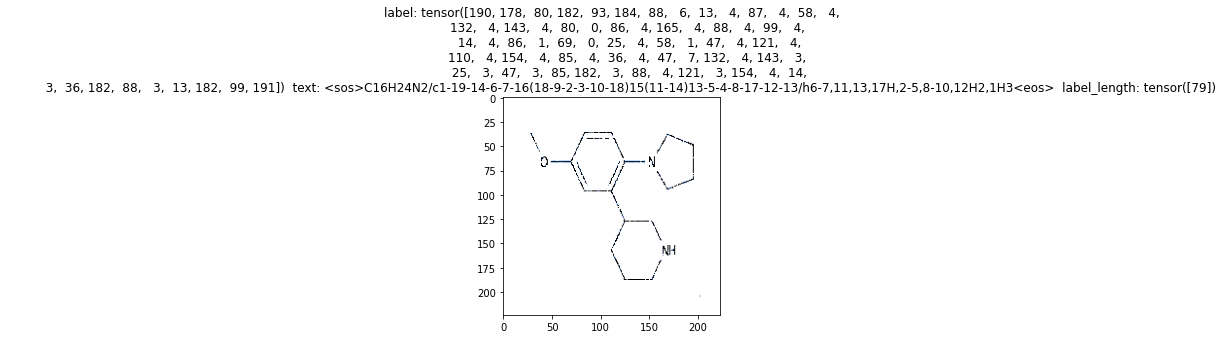

In [16]:
from matplotlib import pyplot as plt

#Veamos como se vería
train_dataset = TrainDataset(train, tokenizer, transform = transforms())

for i in range(1):
    image, label, label_length = train_dataset[i]
    text = tokenizer.seq2text(label.numpy())
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.title(f'label: {label}  text: {text}  label_length: {label_length}')
    plt.show() 

In [17]:
# Modelo: Vision
class Encoder(nn.Module):
    def __init__(self, model_name = 'resnet18', pretrained = False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)
        
        #Almacenamos los features para poder usarlo despues
        self.n_features = self.cnn.fc.in_features
        
        # Eliminamos SelectAdaptivePool2d
        self.cnn.global_pool = nn.Identity()
        
        # Eliminamos Linear
        self.cnn.fc = nn.Identity()

    def forward(self, x):

        features = self.cnn(x)
        
        # En pytorch, la imagen tiene que ser de la forma <batch size, image channel, image height, image width>
        # Nosotros tenemos: <batch size, image height, image width, image channel>
        features = features.permute(0, 2, 3, 1)
        return features

In [18]:
# Para ver de donde hemos sacado los nombres anteriores, ejecutamos la siguiente linea
timm.create_model('resnet18', pretrained = False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
# Capa de atención de Bahdanau con ligeros cambios en las activaciones
# https://arxiv.org/abs/1409.0473

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Mapeo encoder a dim de la atención
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Mapeo decoder a dim de la atención
        self.full_att = nn.Linear(attention_dim, 1)  # Mapeo a 1 para realizar la softmax 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)  # softmax para calcular los pesos

    def forward(self, encoder_out, decoder_hidden):
        att_enc = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att_dec = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att_enc + att_dec.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels) # Son los pesos a aplicar al encoder
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha

In [20]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim, dropout = 0.5):
        super(DecoderWithAttention, self).__init__()
        
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # Capa de atencion
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding
        self.dropout = nn.Dropout(p = self.dropout)
        self.LSTM = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # LSTM del decoder
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # Mapeo inicial para el hidden state de la LSTM
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # Mapeo inicial para el cell state de la LSTM
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # Para cruzar los datos del decoder con el encoder 
        self.sigmoid = nn.Sigmoid() # Para coger los elementos mas importantes del decoder
        self.fc = nn.Linear(decoder_dim, vocab_size)  # Mapeo final del output
        self.init_weights()  # Inicializacion de los pesos

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        
        # LSTM SOLO TIENE DOS DIMENSIONES
        # Eliminamos la dimension de los pixeles con la media
        mean_encoder_out = encoder_out.mean(dim = 1)
        
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_seq, seq_len):

        # Almacenamos las dimensiones que necesitaremos a posteriori
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Ordenamos las secuencias por batch en orden descendiente (pack padding)
        seq_len, sort_indx = seq_len.squeeze(1).sort(dim = 0, descending = True)
        encoder_out = encoder_out[sort_indx]
        encoded_seq = encoded_seq[sort_indx]
        
        # Aplicamos el embedding
        embeddings = self.embedding(encoded_seq)  # (batch_size, max_caption_length, embed_dim)
        
        # Inicializamos hidden state y cell state de la LSTM
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        # decode len (un lapso de tiempo en el futuro) (Elimino el start token)
        decode_len = (seq_len - 1).tolist()
        
        predictions = torch.zeros(batch_size, max(decode_len), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_len), num_pixels).to(self.device)
        for t in range(max(decode_len)):
            # Dentro del batch, miro cuantas  muestras de entrenamiento son más grandes en len que el actual 
            # Recuerda que estan ordenados
            batch_size_t = sum([l > t for l in decode_len])
            
            # Cogemos solo las muestras de entrenamiento mas grandes que la actual y le aplicamos la capa de atención
            # (pack padding)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            
            # Cruzamos los datos del Encoder (pasandolo previamente por la capa de atención) y el Decoder
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # Metemos en la LSTM:
            #  - Hidden state (de la iteración anterior)
            #  - Cell state (de la iteración anterior)
            #  - Embedding del InChi concatenado con el output encoder (aplicada attention)
            h, c = self.LSTM(torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim = 1),  
                             (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_seq, decode_len, alphas, sort_indx
    
    def predict(self, encoder_out, decode_len, tokenizer):
        # Almacenamos las dimensiones que necesitaremos a posteriori
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Inicializamos la predicción con <sos>
        start_tockens = torch.ones(batch_size, dtype = torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        
        # Aplicamos el embedding que hemos entrenado con aterioridad
        embeddings = self.embedding(start_tockens)
        
        # Inicializamos hidden state y cell state de la LSTM
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        
        predictions = torch.zeros(batch_size, decode_len, vocab_size).to(self.device)
        end_condition = torch.zeros(batch_size, dtype = torch.long).to(encoder_out.device)
        for t in range(decode_len):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            
            gate = self.sigmoid(self.f_beta(h))  # (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            h, c = self.LSTM(torch.cat([embeddings, attention_weighted_encoding], dim=1),
                             (h, c))  # (batch_size_t, decoder_dim)
            
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            
            # Bitwise OR operator (mucho mas rapida)
            '''12 = 00001100 (In Binary)
               25 = 00011001 (In Binary)

                Bitwise OR Operation of 12 and 25
                  00001100
                | 00011001
                  ________
                  00011101  = 29 (In decimal)'''
            
            end_condition |= (torch.argmax(preds, -1) == tokenizer.stoi["<eos>"])
            if end_condition.sum() == batch_size:
                break
                
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
def asMinutes(s):
    '''Para pasar de segundos a minutos'''
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [23]:
def timeSince(since, percent):
    '''Estimacion de tiempo total'''
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [24]:
def train_fn(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch,
             encoder_scheduler, decoder_scheduler, device):
    
    # Inicializamos las medidores
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    # Ponemos el Encoder y el Decoder en modo entrenamiento
    encoder.train()
    decoder.train()
    
    # Inicializamos el tiempo
    start = end = time.time()
    
    total_iter = 0
    for num_row, (images, labels, label_len) in enumerate(train_loader):
        
        # Inicio de tiempo para cada iteracion (por batch)
        data_time.update(time.time() - end)
        
        # Almacenamos los inputs en la GPU
        images = images.to(device)
        labels = labels.to(device)
        label_len = label_len.to(device)
        
        batch_size = images.size(0)
        
        # Mapeamos las imagenes al espacio latente del encoder
        features = encoder(images)
        
        # Procesamos los vectores del espacio latente del encoder en el decoder
        predictions, seqs_sorted, decode_len, alphas, sort_indx = decoder(features, labels, label_len)
        
        # Aplicamos pack padding (hemos ordenado previamente los InChis por len en el decoder)
        targets = seqs_sorted[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_len, batch_first = True).data
        targets = pack_padded_sequence(targets, decode_len, batch_first = True).data
        
        # Calculamos el loss
        loss = criterion(predictions, targets)
        
        # Actualizamos el loss en nuestros medidores
        losses.update(loss.item(), batch_size)
        
        # Por si quiero actualizar el loss cada 2/3/4/etc iter (de forma predeterminada en 1)
        if gradient_accumulation > 1:
            loss = loss / gradient_accumulation
            
        # Prpagamos el loss hacia atras
        loss.backward()
        
        # Para evitar exploding gradients
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_grad_norm)
        
        if (num_row + 1) % gradient_accumulation == 0:
            # Actualizamos los pesos
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            # Borramos los gradientes para la siguiente iteración
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            total_iter += 1

        batch_time.update(time.time() - end)
        end = time.time()
        
        if num_row % print_freq == 0 or num_row == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  .format(
                   epoch + 1, num_row, len(train_loader), batch_time = batch_time,
                   data_time = data_time, loss = losses,
                   remain = timeSince(start, float(num_row + 1) / len(train_loader)),
                   encoder_grad_norm = encoder_grad_norm,
                   decoder_grad_norm = decoder_grad_norm
                   ))
            
    return losses.avg

In [25]:
def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device):
    
    # Inicializamos las medidores
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    # Ponemos el Encoder y el Decoder en modo entrenamiento
    encoder.eval()
    decoder.eval()
    
    text_preds = []
    start = end = time.time()
    for num_row, (images) in enumerate(valid_loader):
        
        # Inicio de tiempo para cada iteracion (por batch)
        data_time.update(time.time() - end)
        
        # Almacenamos los inputs en la GPU
        images = images.to(device)
        
        batch_size = images.size(0)
        
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, max_len, tokenizer)
            
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)

        batch_time.update(time.time() - end)
        end = time.time()
        
        if num_row % print_freq == 0 or num_row == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(num_row, len(valid_loader), batch_time=batch_time,
                          data_time = data_time,
                          remain = timeSince(start, float(num_row + 1)/len(valid_loader))
                   ))
            
    text_preds = np.concatenate(text_preds)
    return text_preds

In [26]:
for fold in range(n_fold):
    if fold in trn_fold:

        print(f"========== Fold: {fold} training ==========")
        
        # Cargamos los indices del respectivo fold
        trn_idx = folds[folds['fold'] != fold].index
        val_idx = folds[folds['fold'] == fold].index

        # Cargamos los datos del respectivo fold
        train_folds = folds.loc[trn_idx].reset_index(drop = True)
        valid_folds = folds.loc[val_idx].reset_index(drop = True)
        valid_labels = valid_folds['InChI'].values

        # Cargamos el generador
        train_dataset = TrainDataset(train_folds, tokenizer, transform = transforms())
        valid_dataset = TestDataset(valid_folds, transform = transforms())
        
        # Creamos los dataloader (batch)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = True, 
                                  num_workers = num_workers, 
                                  pin_memory = True,
                                  drop_last = True, 
                                  collate_fn = array_in_out)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size = batch_size, 
                                  shuffle = False, 
                                  num_workers = num_workers,
                                  pin_memory = True, 
                                  drop_last = False)

        
        # Funcion para inicializr sheduler
        
        def get_scheduler(optimizer):
            if modo_scheduler == 'ReduceLROnPlateau':
                scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = factor, patience = patience, verbose = True, eps = eps)
            elif modo_scheduler == 'CosineAnnealingLR':
                scheduler = CosineAnnealingLR(optimizer, T_max = T_max, eta_min = min_lr, last_epoch=-1)
            elif modo_scheduler== 'CosineAnnealingWarmRestarts':
                scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = 1, eta_min = min_lr, last_epoch=-1)
            return scheduler

        # Inicializamos el Encoder y el Decoder
        encoder = Encoder(model_name, pretrained = True) 
        encoder.to(device)

        decoder = DecoderWithAttention(attention_dim = attention_dim,
                                       embed_dim = embed_dim,
                                       encoder_dim = encoder.n_features,  #encoder_dim = 1280,
                                       decoder_dim = decoder_dim,
                                       vocab_size = len(tokenizer),
                                       dropout = dropout,
                                       device = device)
        decoder.to(device)
        
        # Inicializamos los optimizadores y los sheduler
        encoder_optimizer = Adam(encoder.parameters(), lr = encoder_lr, weight_decay = weight_decay, amsgrad = False)
        encoder_scheduler = get_scheduler(encoder_optimizer)
        decoder_optimizer = Adam(decoder.parameters(), lr = decoder_lr, weight_decay = weight_decay, amsgrad = False)
        decoder_scheduler = get_scheduler(decoder_optimizer)
        
        # Incializamos la funcion de perdida especificando que ignore el padding
        criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.stoi["<pad>"])

        best_score = np.inf
        best_loss = np.inf

        for epoch in range(epocas):

            start_time = time.time()

            # Train
            avg_loss = train_fn(train_loader, encoder, decoder, criterion, 
                                encoder_optimizer, decoder_optimizer, epoch, 
                                encoder_scheduler, decoder_scheduler, device)

            # Eval
            text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device)
            text_preds = [f"InChI=1S/{text}" for text in text_preds]
            
            #Imprimimos algunos resultados para ver que tal funciona
            print(f"labels: {valid_labels[:5]}")
            print(f"preds: {text_preds[:5]}")

            # Scoring
            score = Score(valid_labels, text_preds)
            
            # Miramos que sheduler estamos usando, y aplicamos una reduccion
            if isinstance(encoder_scheduler, ReduceLROnPlateau):
                encoder_scheduler.step(score)
            elif isinstance(encoder_scheduler, CosineAnnealingLR):
                encoder_scheduler.step()
            elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
                encoder_scheduler.step()

            if isinstance(decoder_scheduler, ReduceLROnPlateau):
                decoder_scheduler.step(score)
            elif isinstance(decoder_scheduler, CosineAnnealingLR):
                decoder_scheduler.step()
            elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
                decoder_scheduler.step()

            elapsed = time.time() - start_time

            print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
            print(f'Epoch {epoch+1} - Score: {score:.4f}')

            if score < best_score:
                best_score = score
                print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'encoder': encoder.state_dict(), 
                            'encoder_optimizer': encoder_optimizer.state_dict(), 
                            'encoder_scheduler': encoder_scheduler.state_dict(), 
                            'decoder': decoder.state_dict(), 
                            'decoder_optimizer': decoder_optimizer.state_dict(), 
                            'decoder_scheduler': decoder_scheduler.state_dict(), 
                            'text_preds': text_preds,
                           },
                            f'{model_name}_fold{fold}_score{score}_epoch{epoch}.pth')
                
    # Solo entrenare un fold debug
    break

========== Fold: 0 training ==========


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


Epoch: [1][0/250] Data 1.908 (1.908) Elapsed 0m 4s (remain 19m 34s) Loss: 5.2604(5.2604) Encoder Grad: 0.9557  Decoder Grad: 0.7700  
Epoch: [1][249/250] Data 0.000 (0.008) Elapsed 5m 2s (remain 0m 0s) Loss: 1.5756(2.1130) Encoder Grad: 0.3726  Decoder Grad: 0.3650  
EVAL: [0/63] Data 1.284 (1.284) Elapsed 0m 2s (remain 2m 26s) 
EVAL: [62/63] Data 0.000 (0.021) Elapsed 0m 57s (remain 0m 0s) 
labels: ['InChI=1S/C16H24N2O/c1-19-14-6-7-16(18-9-2-3-10-18)15(11-14)13-5-4-8-17-12-13/h6-7,11,13,17H,2-5,8-10,12H2,1H3'
 'InChI=1S/C13H17FN2O2/c1-2-3-7-18-8-6-16-13(17)11-5-4-10(14)9-12(11)15/h2,4-5,9H,1,3,6-8,15H2,(H,16,17)'
 'InChI=1S/C11H16FN3/c1-15(7-9-4-2-3-5-9)11-6-10(12)13-8-14-11/h6,8-9H,2-5,7H2,1H3'
 'InChI=1S/C23H26ClN5O2S/c1-5-13(2)19(26-22(31)25-18-11-6-8-14(3)15(18)4)20(30)27-23-29-28-21(32-23)16-9-7-10-17(24)12-16/h6-13,19H,5H2,1-4H3,(H2,25,26,31)(H,27,29,30)/t13-,19-/m0/s1'
 'InChI=1S/C20H22N2O3S/c1-3-16-13-22(17-10-5-6-11-18(17)26-16)20(24)21-15-9-7-8-14(12-15)19(23)25-4-2/h5-12,16